In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
stock_symbol = "AAPL"  # Apple Inc.

# Download data (past 5 years)
df = yf.download(stock_symbol, start="2019-01-01", end="2024-01-01")

# Save as CSV
df.to_csv("AAPL_stock_data.csv")

# Show data
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2019-01-02,37.667187,37.889013,36.787045,36.944469,148158800
2019-01-03,33.915249,34.757226,33.869929,34.342199,365248800
2019-01-04,35.363075,35.432248,34.299275,34.473394,234428400
2019-01-07,35.284351,35.499022,34.800155,35.468013,219111200
2019-01-08,35.956985,36.212204,35.425085,35.673145,164101200


In [4]:
# Select 'Close' price for forecasting
df = df[['Close']]
df.dropna(inplace=True)

# Normalize data (for LSTM)
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Convert back to DataFrame
df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=['Close'])
df_scaled.head()


,Close
Date,
2019-01-02,0.023016
2019-01-03,0.000000
2019-01-04,0.008882
2019-01-07,0.008399
2019-01-08,0.012525


In [5]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity
result = adfuller(df['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')  # If < 0.05, data is stationary


ADF Statistic: -1.2050005673847575
p-value: 0.6714409032652973


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\P

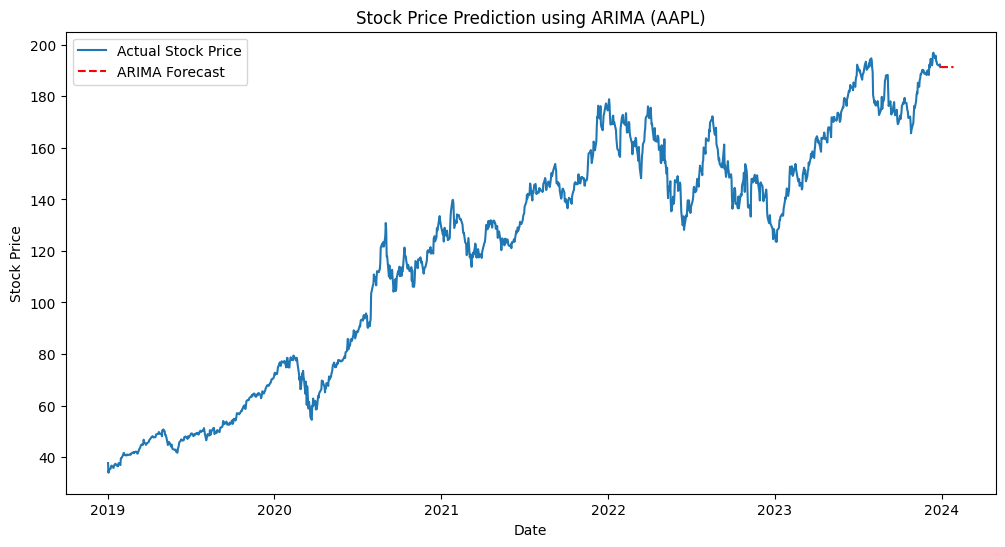

In [6]:
# Fit ARIMA model
arima_model = ARIMA(df['Close'], order=(5, 1, 0))  # (p, d, q)
arima_result = arima_model.fit()

# Forecast next 30 days
forecast = arima_result.forecast(steps=30)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label="Actual Stock Price")
plt.plot(pd.date_range(df.index[-1], periods=30, freq="D"), forecast, label="ARIMA Forecast", linestyle="dashed", color='red')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"Stock Price Prediction using ARIMA ({stock_symbol})")
plt.legend()
plt.show()


In [7]:
# Create sequences for LSTM
def create_sequences(data, time_steps=50):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 50
X, y = create_sequences(df_scaled.values, time_steps)

# Split into train & test sets
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]


In [8]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=25, batch_size=32)


Epoch 1/25


C:\Users\APPLE\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0853
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0074
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0041
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0036
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0033
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0036
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0033
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0028
Epoch 9/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0028
Epoch 10/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027
Epoch 11/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0028
Epoch 12/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0030
Epoch 13/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027
Epoch 14/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024
Epoch 15/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0023
Epoch 16/25
31/

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


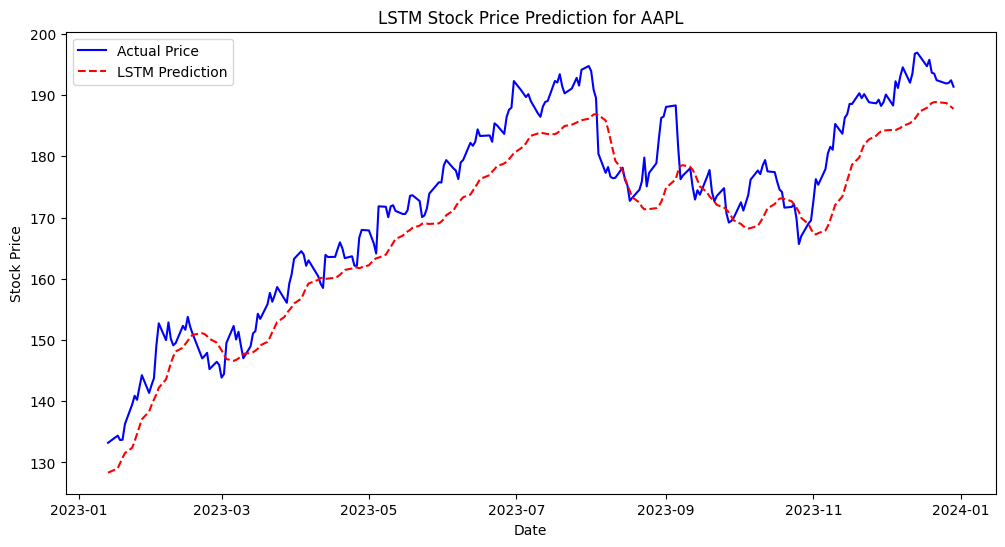

In [9]:
# Predict on test data
predictions = model.predict(X_test)

# Convert predictions back to original scale
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], y_test_original, label="Actual Price", color="blue")
plt.plot(df.index[-len(y_test):], predictions, label="LSTM Prediction", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"LSTM Stock Price Prediction for {stock_symbol}")
plt.legend()
plt.show()


In [10]:
from sklearn.metrics import mean_absolute_error

# Evaluate ARIMA
arima_mae = mean_absolute_error(df['Close'][-30:], forecast)
print(f"ARIMA MAE: {arima_mae:.2f}")

# Evaluate LSTM
lstm_mae = mean_absolute_error(y_test_original, predictions)
print(f"LSTM MAE: {lstm_mae:.2f}")


ARIMA MAE: 2.25
LSTM MAE: 5.22
